In [1]:
import requests
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#list of top 9 stocks from: https://fortune.com/future-50/
tickerlist = ['CRWD','TWLO','DDOG','SQ','ABNB','MRNA','JDHIY','DOCU','MELI']
tickerlist = tickerlist[:5] #only get 5 api calls per minute

# Extracting the Data

In [3]:
key = open("key.txt", "r").read()
# url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&datatype=csv&apikey=' + key
base_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&datatype=csv'
base_url += '&apikey=' + key
for ticker in tickerlist:
    url = base_url + '&symbol=' + ticker
    r = requests.get(url)
    filename = ticker + '.csv'
    csv_file = open(filename, "wb")
    n = csv_file.write(r._content)
    csv_file.close()

   timestamp     open      high       low   close   volume ticker
0 2022-06-08  176.000  180.4700  175.0500  178.84  2885756   CRWD
1 2022-06-07  166.100  181.8900  165.8419  176.68  5790887   CRWD
2 2022-06-06  167.480  171.3500  162.7100  168.97  6826036   CRWD
3 2022-06-03  165.864  170.8199  160.6900  162.10  9303161   CRWD
4 2022-06-02  161.000  176.5600  160.9900  174.02  8498735   CRWD


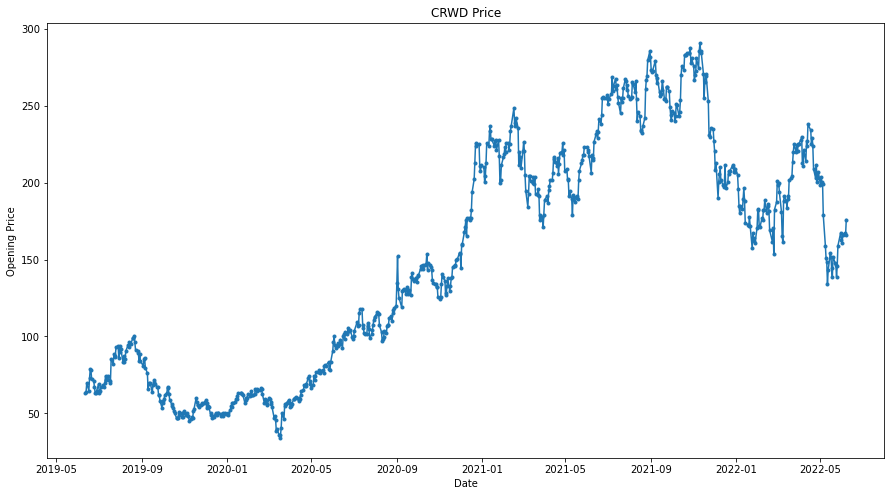

   timestamp    open      high      low   close   volume ticker
0 2022-06-08  107.12  110.3099  105.781  108.39  1891902   TWLO
1 2022-06-07   99.50  108.0800   98.855  107.43  3622322   TWLO
2 2022-06-06  104.58  105.2700   99.210  101.34  2720595   TWLO
3 2022-06-03  106.05  107.1300  100.760  101.74  3022087   TWLO
4 2022-06-02   99.00  110.9800   98.300  109.21  3711309   TWLO


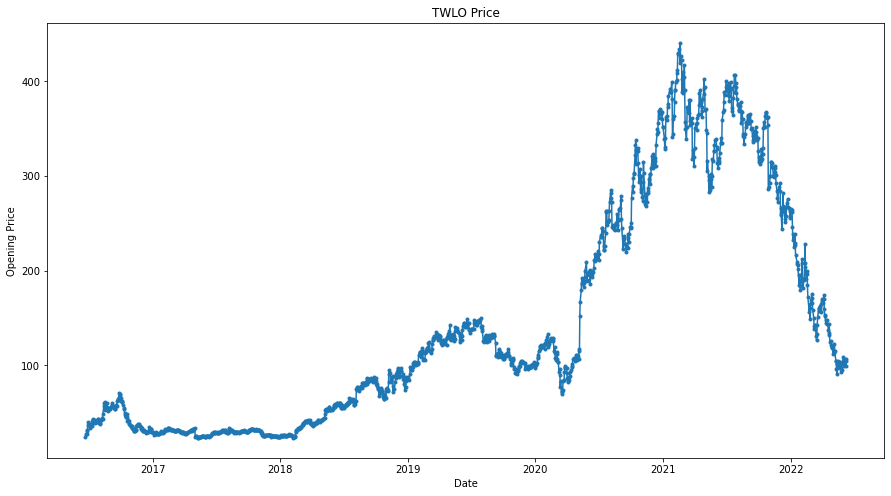

   timestamp    open    high     low   close    volume ticker
0 2022-06-08  106.56  111.82  106.56  107.35   3631459   DDOG
1 2022-06-07  101.58  110.40  101.17  108.06   4300767   DDOG
2 2022-06-06  108.38  109.41  102.38  103.16   3962140   DDOG
3 2022-06-03  106.82  110.95  103.78  105.44   5764963   DDOG
4 2022-06-02   97.39  116.62   96.20  110.08  15399706   DDOG


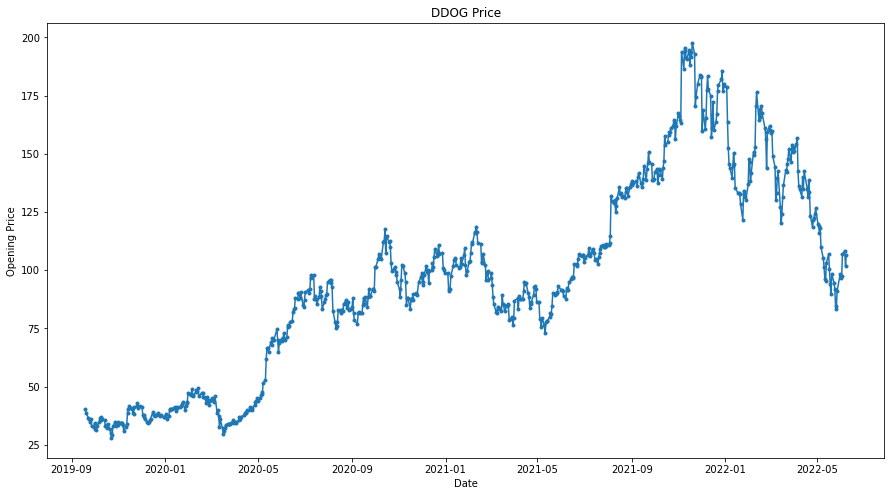

In [14]:
df = pd.DataFrame()

for ticker in tickerlist[:3]: #only doing 3 right now due to api call freq limit
    
    load_cmd = ticker + " = pd.read_csv('" + ticker + ".csv')" #<ticker> = pd.read_csv('<ticker>.csv')
#     print(load_cmd)
    exec(load_cmd)
    
    time_cmd = ticker + "['timestamp'] = pd.to_datetime(" + ticker + "['timestamp'], infer_datetime_format=True)"
#     print(time_cmd)
    exec(time_cmd)
    
    ticker_cmd = ticker + "['ticker'] = '" + ticker + "'"
#     print(ticker_cmd)
    exec(ticker_cmd)

    exec("print(" + ticker + ".head())")
    plt.figure(figsize=(15,8))
    
    plot = "plt.plot(" + ticker + "['timestamp']," + ticker + "['open'], marker='.')"
    exec(plot)
    
    plt.xlabel("Date")
    plt.ylabel("Opening Price")
    
    title = "plt.title('" + ticker + " Price')"
    exec(title)
    
    append = "df = df.append(" + ticker + ")"
    exec(append)
    
    plt.show()

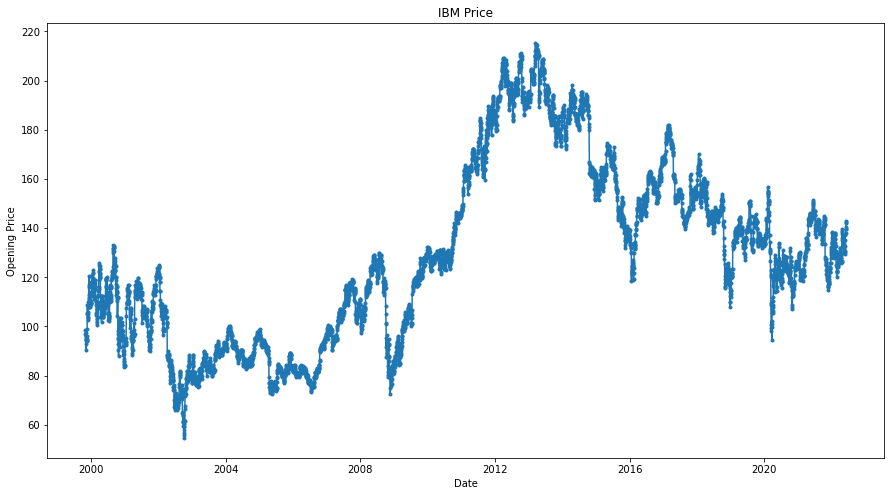

In [52]:
plt.figure(figsize=(15,8))
plt.plot(df["timestamp"], df["open"], marker='.')
plt.xlabel("Date")
plt.ylabel("Opening Price")
plt.title("IBM Price")
plt.show()

In [15]:
df

,timestamp,open,high,low,close,volume,ticker
0,2022-06-08,176.000,180.4700,175.0500,178.84,2885756,CRWD
1,2022-06-07,166.100,181.8900,165.8419,176.68,5790887,CRWD
2,2022-06-06,167.480,171.3500,162.7100,168.97,6826036,CRWD
3,2022-06-03,165.864,170.8199,160.6900,162.10,9303161,CRWD
4,2022-06-02,161.000,176.5600,160.9900,174.02,8498735,CRWD
...,...,...,...,...,...,...,...
681,2019-09-25,34.600,35.6000,34.2000,35.25,3027990,DDOG
682,2019-09-24,36.010,37.1200,34.0600,34.50,3210350,DDOG
683,2019-09-23,36.580,38.1500,35.7500,36.11,2247259,DDOG
684,2019-09-20,38.590,39.2000,36.1500,36.15,3330499,DDOG


# Loading the Data
## Creating the Spark DataFrame
This can also be done by just loading the data directly from CSV rather than through pandas

Code demo: https://pages.databricks.com/rs/094-YMS-629/images/Fine-Grained-Time-Series-Forecasting.html
```
from pyspark.sql.types import *

# structure of the training data set
train_schema = StructType([
  StructField('date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('sales', IntegerType())
  ])

# read the training file into a dataframe
train = spark.read.csv(
  '/FileStore/tables/demand_forecast/train/train.csv', 
  header=True, 
  schema=train_schema
  )

# make the dataframe queriable as a temporary view
train.createOrReplaceTempView('train')
```

In [16]:
spark = SparkSession.builder.master('local').getOrCreate()
# the parameter for master will need to be changed to use the spark cluster in docker
# https://spark.apache.org/docs/latest/api/java/org/apache/spark/sql/SparkSession.Builder.html#master-java.lang.String-

sdf = spark.createDataFrame(df)
sdf.printSchema() #data type of each col
sdf.show(5) #It gives you head of pandas DataFrame
sdf.count()

root
 |-- timestamp: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- ticker: string (nullable = true)

+-------------------+-------+--------+--------+------+-------+------+
|          timestamp|   open|    high|     low| close| volume|ticker|
+-------------------+-------+--------+--------+------+-------+------+
|2022-06-08 00:00:00|  176.0|  180.47|  175.05|178.84|2885756|  CRWD|
|2022-06-07 00:00:00|  166.1|  181.89|165.8419|176.68|5790887|  CRWD|
|2022-06-06 00:00:00| 167.48|  171.35|  162.71|168.97|6826036|  CRWD|
|2022-06-03 00:00:00|165.864|170.8199|  160.69| 162.1|9303161|  CRWD|
|2022-06-02 00:00:00|  161.0|  176.56|  160.99|174.02|8498735|  CRWD|
+-------------------+-------+--------+--------+------+-------+------+
only showing top 5 rows



2942